In [ ]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [9]:
import logging
from pathlib import Path

import polars as pl

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance import (
    get_confusion_matrix,
    get_model_predictions,
    plot_pr_curve,
    plot_roc_curve,
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
configure_logging(stream=False)

In [10]:
# Load model
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic/model/PatchTST_20250516-095409.pt"
)

# Load data from database
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df, features, 3000, RANDOM_SEED
)

train_val_loader, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)


In [11]:
probs, y_true = get_model_predictions(
    model,
    test_loader,
)

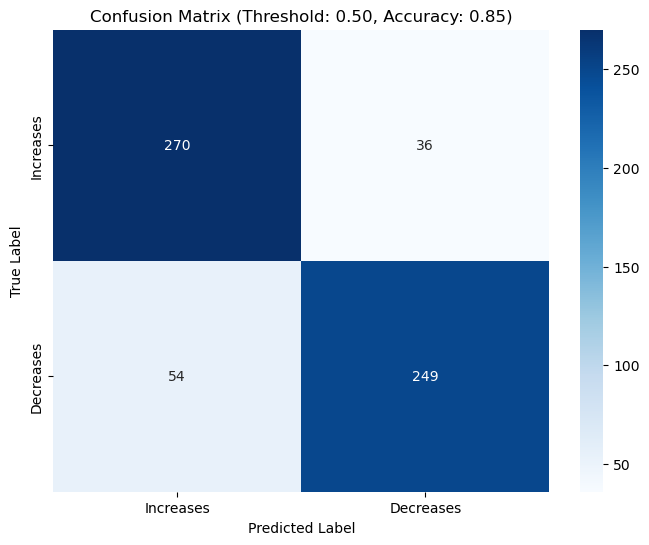

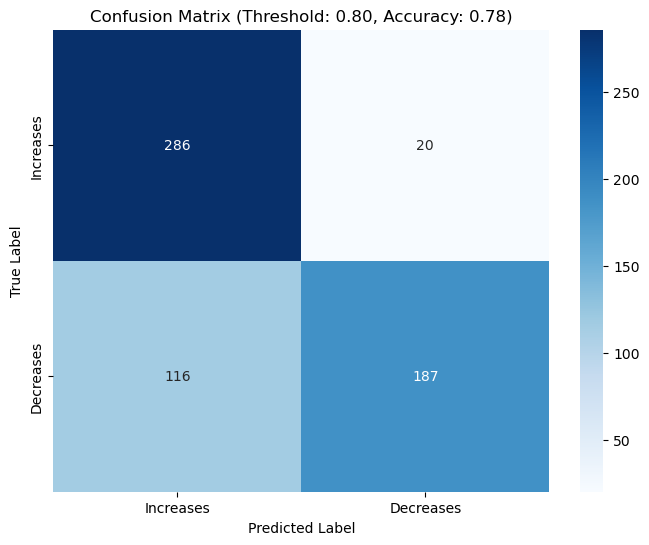

In [12]:
conf_matrix = get_confusion_matrix(probs, y_true, threshold=0.5)
conf_matrix = get_confusion_matrix(probs, y_true, threshold=0.8)

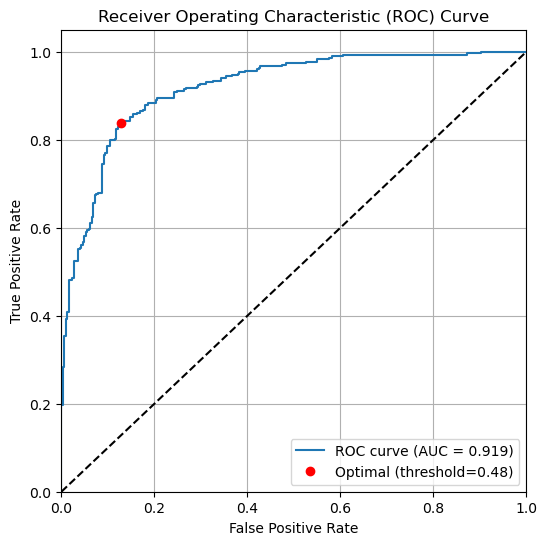

In [13]:
plot_roc_curve(probs, y_true)

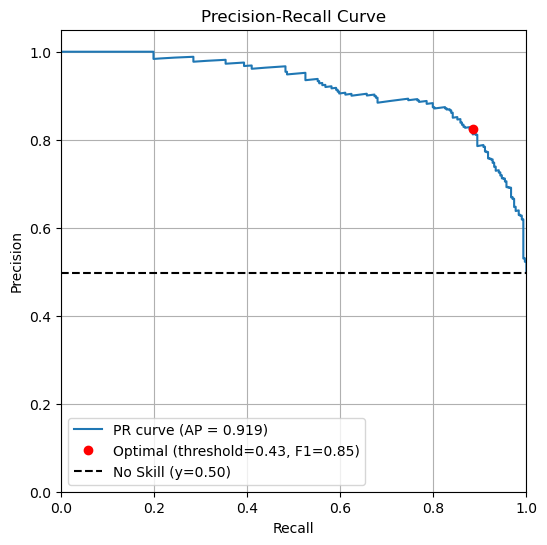

In [14]:
ap_score, optimal_pr_threshold = plot_pr_curve(probs, y_true)  # ap = average precision

no skill line might appear at .51 and not .50 because of very slight class imbalance in the test set due to groupshufflesplit. this imbalance is not enough to affect the results in any meaningful way